In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tensorflow as tf

from torch.autograd import Variable
from torchvision import models

from tensorflow import keras
from keras.preprocessing import image

import PIL
import torch
import torchvision

import matplotlib.pyplot as plt
from sklearn import svm, datasets, metrics

torch.manual_seed(777)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
        torch.cuda.manual_seed(777)

/home/jun/anaconda3/envs/cv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_path = '/home/jun/Github/BoVW/dataset/train'
test_path = '/home/jun/Github/BoVW/dataset/test'
ckpt_path = './models'

In [3]:
epochs = 20
batch_size = 128
model_name = 'vgg19' #'resnet18','resnet50','resnet101','alexnet','vgg16','vgg19','densenet121','densenet161','mobilenet','squeezenet'

In [4]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=7, dim=128, alpha=100.0,
                 normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)
        vlad = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad

In [5]:
class EmbedNet(nn.Module):
    def __init__(self, base_model, net_vlad):
        super(EmbedNet, self).__init__()
        self.base_model = base_model
        self.net_vlad = net_vlad

    def forward(self, x):
        x = self.base_model(x)
        embedded_x = self.net_vlad(x)
        return embedded_x
      
class TripletNet(nn.Module):
    def __init__(self, embed_net):
        super(TripletNet, self).__init__()
        self.embed_net = embed_net

    def forward(self, a, p, n):
        embedded_a = self.embed_net(a)
        embedded_p = self.embed_net(p)
        embedded_n = self.embed_net(n)
        return embedded_a, embedded_p, embedded_n

    def feature_extract(self, x):
        return self.embed_net(x)

In [6]:
class HardTripletLoss(nn.Module):
    """Hard/Hardest Triplet Loss
    (pytorch implementation of https://omoindrot.github.io/triplet-loss)
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    """
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        self.margin = margin
        self.hardest = hardest
        self.squared = squared

    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)
        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)

        if self.hardest:
            # Get the hardest positive pairs
            mask_anchor_positive = _get_anchor_positive_triplet_mask(labels).float()
            valid_positive_dist = pairwise_dist * mask_anchor_positive
            hardest_positive_dist, _ = torch.max(valid_positive_dist, dim=1, keepdim=True)

            # Get the hardest negative pairs
            mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
            max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
            anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
            hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

            # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
            triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + 0.1)
            triplet_loss = torch.mean(triplet_loss)
        else:
            anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
            anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

            # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
            # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
            # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
            # and the 2nd (batch_size, 1, batch_size)
            loss = anc_pos_dist - anc_neg_dist + self.margin

            mask = _get_triplet_mask(labels).float()
            triplet_loss = loss * mask

            # Remove negative losses (i.e. the easy triplets)
            triplet_loss = F.relu(triplet_loss)

            # Count number of hard triplets (where triplet_loss > 0)
            hard_triplets = torch.gt(triplet_loss, 1e-16).float()
            num_hard_triplets = torch.sum(hard_triplets)

            triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)

        return triplet_loss


def _pairwise_distance(x, squared=False, eps=1e-16):
    # Compute the 2D matrix of distances between all the embeddings.

    cor_mat = torch.matmul(x, x.t())
    norm_mat = cor_mat.diag()
    distances = norm_mat.unsqueeze(1) - 2 * cor_mat + norm_mat.unsqueeze(0)
    distances = F.relu(distances)

    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    # Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)

    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (i_equal_k ^ 1)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

In [7]:
def initialize_model(model_name, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    base_model = None
    dim = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        encoder = models.resnet18(pretrained=use_pretrained)
        base_model = nn.Sequential(
        encoder.conv1,
        encoder.bn1,
        encoder.relu,
        encoder.maxpool,
        encoder.layer1,
        encoder.layer2,
        encoder.layer3,
        encoder.layer4,
        )
        dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        encoder = models.resnet50(pretrained=use_pretrained)
        base_model = nn.Sequential(
        encoder.conv1,
        encoder.bn1,
        encoder.relu,
        encoder.maxpool,
        encoder.layer1,
        encoder.layer2,
        encoder.layer3,
        encoder.layer4,
        )
        dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)
    elif model_name == "resnet101":
        """ Resnet101
        """
        encoder = models.resnet101(pretrained=use_pretrained)
        base_model = nn.Sequential(
        encoder.conv1,
        encoder.bn1,
        encoder.relu,
        encoder.maxpool,
        encoder.layer1,
        encoder.layer2,
        encoder.layer3,
        encoder.layer4,
        )
        dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)
        
    elif model_name == "alexnet":
        """ alexnet
        """
        encoder = models.alexnet(pretrained=use_pretrained)
        base_model = nn.Sequential(
        encoder.features,
        
        )
        dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)
        

    elif model_name == "vgg16":
        """ vgg16
        """
        encoder = models.vgg16(pretrained=use_pretrained)
        base_model = nn.Sequential(
        encoder.features,
        
        )
        dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)
    elif model_name == "vgg19":
        """ vgg19
        """
        encoder = models.vgg19(pretrained=use_pretrained)
        base_model = nn.Sequential(
        encoder.features,
        
        )
        dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)
  
    elif model_name == "densenet121":
        """ densenet121
        """
        encoder = models.densenet121(pretrained=use_pretrained)
        base_model = nn.Sequential(
        encoder.features,
        
        )
        dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)
        
    elif model_name == "densenet161":
        """ densenet161
        """
        encoder = models.densenet161(pretrained=use_pretrained)
        base_model = nn.Sequential(
        encoder.features,
        
        )
        dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)
        
    elif model_name == 'mobilenet':
        """ mobilenet_v2
        """
        encoder = models.mobilenet_v2(pretrained=use_pretrained)
        base_model = nn.Sequential(
        encoder.features,

        )
        dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)
    elif model_name == 'squeezenet':
        """ squeezenet
        """
        encoder = models.squeezenet.squeezenet1_1(pretrained=use_pretrained)
        base_model = nn.Sequential(
        encoder.features,

        )
        dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

    else:
        print("Invalid model name, exiting...")
        

    return base_model, dim

In [8]:
model_list = ['resnet18','resnet50','resnet101','alexnet','vgg16','vgg19','densenet121','densenet161','mobilenet','squeezenet']
base_model_dict = {}

for i in model_list:
    base_model,dim =initialize_model(i,use_pretrained=True)
    print(i,'is completed , dim is ',dim)
    base_model_dict[i]=[base_model,dim]

resnet18 is completed , dim is  512
resnet50 is completed , dim is  2048
resnet101 is completed , dim is  2048
alexnet is completed , dim is  256
vgg16 is completed , dim is  512
vgg19 is completed , dim is  512
densenet121 is completed , dim is  1024
densenet161 is completed , dim is  2208
mobilenet is completed , dim is  1280
squeezenet is completed , dim is  256


In [9]:
model_name = model_name
base_model = base_model_dict[model_name][0]
dim = base_model_dict[model_name][1]

In [10]:
# Define model for embedding
net_vlad = NetVLAD(num_clusters=7, dim=dim, alpha=1.0)
model = EmbedNet(base_model, net_vlad).cuda()

In [11]:
# Define loss
criterion = HardTripletLoss(margin=0.1).cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [12]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),                    
#     torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
#     torchvision.transforms.RandomHorizontalFlip(),               
    torchvision.transforms.ToTensor()
    
])

train_imagenet_data = torchvision.datasets.ImageFolder(train_path, transform=transforms)
train_data_loader = torch.utils.data.DataLoader(train_imagenet_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

In [13]:
import os

globaliter = 0
last_ckpt_path = None
for epoch in range(epochs):
    print(epoch)
    for batch_idx, (train_image,train_label) in enumerate(train_data_loader) :
        output_train = model(train_image.cuda())
        triplet_loss = criterion(output_train, train_label.cuda())
        optimizer.zero_grad()
        triplet_loss.backward(retain_graph=True)
        optimizer.step()
        print(epoch,globaliter,batch_idx,triplet_loss.item())
        globaliter += 1
    model_save_name = '{}_model_{}_{}.pt'.format(model_name,epoch,batch_size)
    path = os.path.join(ckpt_path,model_save_name)
  
    torch.save(model.state_dict(), path)
    last_ckpt_path = path

0
0 0 0 0.08399081975221634
0 1 1 0.08651972562074661
0 2 2 0.08368825912475586
0 3 3 0.08157457411289215
0 4 4 0.08101625740528107
0 5 5 0.08171243220567703
0 6 6 0.08090014010667801
1
1 7 0 0.07880055904388428
1 8 1 0.07882878184318542
1 9 2 0.07686334103345871
1 10 3 0.07728876918554306
1 11 4 0.07748203724622726
1 12 5 0.07564118504524231
1 13 6 0.07698038965463638
2
2 14 0 0.07278754562139511
2 15 1 0.07197020947933197
2 16 2 0.0739835649728775
2 17 3 0.07045874744653702
2 18 4 0.07061938941478729
2 19 5 0.06846331804990768
2 20 6 0.0672360211610794
3
3 21 0 0.062502421438694
3 22 1 0.06516506522893906
3 23 2 0.06423038989305496
3 24 3 0.0681571438908577
3 25 4 0.06487885862588882
3 26 5 0.06012105941772461
3 27 6 0.05943481624126434
4
4 28 0 0.0614909790456295
4 29 1 0.05473606288433075
4 30 2 0.058217015117406845
4 31 3 0.05655135214328766
4 32 4 0.05635558441281319
4 33 5 0.05256614834070206
4 34 6 0.04453381896018982
5
5 35 0 0.05670519918203354
5 36 1 0.048996612429618835
5 3

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 7.92 GiB total capacity; 5.72 GiB already allocated; 137.56 MiB free; 6.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
state_dict = torch.load(last_ckpt_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),                    
#     torchvision.transforms.ColorJitter(hue=.05, saturation=.05), 
#     torchvision.transforms.RandomHorizontalFlip(),               
    torchvision.transforms.ToTensor()
    
])

query_imagenet_data = torchvision.datasets.ImageFolder(test_path, transform=transforms)
query_data_loader = torch.utils.data.DataLoader(query_imagenet_data,
                                          shuffle=True,
                                          batch_size=210,
                                          num_workers=0)


refer_imagenet_data = torchvision.datasets.ImageFolder(test_path, transform=transforms)
refer_data_loader = torch.utils.data.DataLoader(refer_imagenet_data,
                                          shuffle=False,
                                          batch_size=210,
                                          num_workers=0)

In [16]:
refer_np =None
refer_label = None
query_np = None
query_label = None

for query_image, query_label in query_data_loader:
    query_output = model(query_image.cuda()) 
    X_query = query_output.cpu().data.numpy()
    query_label = query_label.cpu().data.numpy()
    query_np = query_image.cpu().data.numpy()

for refer_image, refer_label in refer_data_loader:
    refer_output = model(refer_image.cuda()) 
    X_refer = refer_output.cpu().data.numpy()
    refer_label = refer_label.cpu().data.numpy()
    refer_np = refer_image.cpu().data.numpy()

RuntimeError: CUDA out of memory. Tried to allocate 840.00 MiB (GPU 0; 7.92 GiB total capacity; 5.83 GiB already allocated; 151.50 MiB free; 6.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [96]:
select_idx = 20

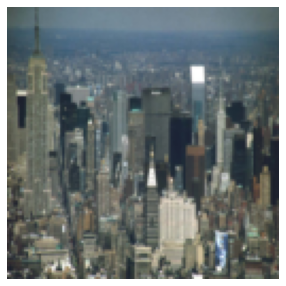

In [97]:
query_img = np.transpose(query_np, (0, 2, 3, 1))
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(query_img[select_idx])

In [98]:
len(query_img)

210

In [100]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=210, algorithm ='ball_tree').fit(X_refer) # X_refer shape (batch size , dimension)
distances, indices = nbrs.kneighbors(X_query)   # X_query shape (batch_size, dimension)

In [101]:
print(X_query.shape)  # query vector shape : batch size, dimension
print(query_np.shape)  # query numpy shape : batch size , channel , height, width
print(query_label.shape)   # query label shape : batch size[class idx] 

(210, 3584)
(210, 3, 128, 128)
(210,)


In [102]:
count_to_class ={}
for i in refer_label:
    if not i in count_to_class:
        count_to_class[i]=1
    else:
        count_to_class[i]+=1

In [103]:
count_to_class

{0: 30, 1: 30, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30}

In [104]:
# y_true : label(interger), y_pred : label(list)
def get_TFtable(y_true,y_pred):
    table = []
    TP =[]
    FP = []
    for i in y_pred:
        if i==y_true:
            table.append('true')
        else:
            table.append('false')
    return table

def evaluateAP(y_true, y_pred):
    tf_table=get_TFtable(y_true,y_pred)
    reverse_table = tf_table.copy()
    reverse_table.reverse()
    index_T=len(reverse_table)-reverse_table.index('true')-1 
    K = count_to_class[y_true]
    count_TP =0
    sum_precision = 0
    
    for i in range(0,index_T+1):
        if tf_table[i]=='true':
            count_TP+=1
            recall = count_TP/index_T
            precision = count_TP/(i+1)
            sum_precision += precision
#         print('t_i : {} , recall : {} , precision : {} '.format(i,recall,precision))
    print('Average Precision query {} : {} '.format(y_true,sum_precision / K))
    return sum_precision /K

In [105]:
import itertools

sum_to_class ={}
map_to_class = {}

total_MAP = 0
sum_AP = 0

num_classes = 7
confusion_matrix = torch.zeros(num_classes, num_classes)

for i in range(0,len(query_label)):
    keys = np.ndarray.tolist(indices[i]) 
    values = np.ndarray.tolist(distances[i]) 

    find_dict = dict(zip(keys,values)) 

    similar = sorted(find_dict.items(), key=lambda find_dict: values)[:30]
    similar_idx = [i[0] for i total_MAP in similar]

    y_true = query_label[i]
#   print('query label : ',y_true)
  
    y_pred = [refer_label[i] for i in similar_idx]
#   print('retrieval label : ',y_pred)
  
    AP = evaluateAP(y_true,y_pred)
    sum_AP += AP
    if not y_true in sum_to_class.keys():
        sum_to_class[y_true] = AP
    else:
        sum_to_class[y_true] += AP
  
total_MAP = sum_AP/len(query_label)

for key,value in sum_to_class.items():
    map_to_class[key]=sum_to_class[key]/count_to_class[key]

Average Precision query 2 : 0.8303761778155839 
Average Precision query 0 : 0.46366213035330683 
Average Precision query 3 : 0.6010321109250418 
Average Precision query 0 : 0.9187314031222077 
Average Precision query 5 : 0.3759714381479087 
Average Precision query 3 : 0.9262956413531125 
Average Precision query 0 : 0.5764501941127329 
Average Precision query 6 : 0.8938511969086681 
Average Precision query 1 : 1.0 
Average Precision query 3 : 0.8630036630036629 
Average Precision query 3 : 0.813273646871842 
Average Precision query 5 : 0.30569160255892586 
Average Precision query 0 : 0.40644451374980844 
Average Precision query 2 : 0.7641126349857 
Average Precision query 0 : 0.19896724532212712 
Average Precision query 4 : 0.2492369341853346 
Average Precision query 6 : 0.785367811765113 
Average Precision query 6 : 0.4528367465867466 
Average Precision query 3 : 0.8977011494252873 
Average Precision query 2 : 0.14812564080929894 
Average Precision query 0 : 0.9 
Average Precision quer

In [109]:
total_MAP

0.6637446381640942

In [110]:
map_to_class

{2: 0.7406034378827682,
 0: 0.6159181788400634,
 3: 0.8515023427064027,
 5: 0.3381809786156609,
 6: 0.7319736119290685,
 1: 1.0,
 4: 0.3680339171746952}

In [106]:
hist_dict={}
hist_list =[]
for name, idx in refer_imagenet_data.class_to_idx.items():
    hist_dict = {'base_model':model_name,'epochs':epochs,'batch_size':batch_size,'class_name':name,'map_to_class':map_to_class[idx],'count_to_class':count_to_class[idx]}
    hist_list.append(hist_dict)
    print('base model name : {} , epoch : {}, batch size : {} , class name : {} , Mean Average Precision to class : {} , query counts to class : {}'.format(hist_dict['base_model'],hist_dict['epochs'] ,hist_dict['batch_size'],hist_dict['class_name'],hist_dict['map_to_class'],hist_dict['count_to_class']))


base model name : resnet18 , epoch : 20, batch size : 128 , class name : city , Mean Average Precision to class : 0.6159181788400634 , query counts to class : 30
base model name : resnet18 , epoch : 20, batch size : 128 , class name : face , Mean Average Precision to class : 1.0 , query counts to class : 30
base model name : resnet18 , epoch : 20, batch size : 128 , class name : green , Mean Average Precision to class : 0.7406034378827682 , query counts to class : 30
base model name : resnet18 , epoch : 20, batch size : 128 , class name : house_building , Mean Average Precision to class : 0.8515023427064027 , query counts to class : 30
base model name : resnet18 , epoch : 20, batch size : 128 , class name : house_indoor , Mean Average Precision to class : 0.3680339171746952 , query counts to class : 30
base model name : resnet18 , epoch : 20, batch size : 128 , class name : office , Mean Average Precision to class : 0.3381809786156609 , query counts to class : 30
base model name : resn